In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ir-project/comments_test.csv
/kaggle/input/ir-project/comments_train.csv
/kaggle/input/ir-project/comments_val.csv


In [8]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [9]:
import pandas as pd
train = pd.read_csv('/kaggle/input/ir-project/comments_train.csv')
val = pd.read_csv('/kaggle/input/ir-project/comments_val.csv')
test = pd.read_csv('/kaggle/input/ir-project/comments_test.csv')

In [10]:
X_train = train['comment'].values
y_train = train['polarity'].values
X_val = val['comment'].values
y_val = val['polarity'].values
X_test = test['comment'].values
y_test = test['polarity'].values

In [11]:
tk = Tokenizer(num_words=NB_WORDS,
               split=" ")
tk.fit_on_texts(X_train)

In [12]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [13]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_val.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 17630
VALIDATION DATA: 5877
TESTING DATA: 5877


In [14]:
MAX_LEN = 308 # Maximum number of words in a sequence
EMB_DIM = 8 # Embedding dimension
NB_WORDS = 10000 # Number of words to include in our vocab

In [15]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [16]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

In [17]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [18]:
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
from tensorflow.keras.optimizers import legacy


def create_bert(bert_model, max_len=MAX_LEN):
    ##params###
    opt = legacy.Adam(lr=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    if len(embeddings.shape) == 2:
        embeddings = tf.keras.layers.Reshape((1, embeddings.shape[1]))(embeddings)
        embeddings = tf.keras.layers.Flatten()(embeddings)

    output = tf.keras.layers.Dense(2, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    model.compile(opt, loss=loss, metrics=accuracy)

    return model

In [20]:
bert_model = create_bert(bert_model, MAX_LEN)
bert_model.summary()

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 308)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 308)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 308,                                           

In [21]:
history_bert = bert_model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=20, batch_size=4)

Epoch 1/20
4408/4408 [==============================] - 1037s 231ms/step - loss: 0.0530 - categorical_accuracy: 0.9824 - val_loss: 0.0432 - val_categorical_accuracy: 0.9854
Epoch 2/20
4408/4408 [==============================] - 1017s 231ms/step - loss: 0.0267 - categorical_accuracy: 0.9906 - val_loss: 0.0510 - val_categorical_accuracy: 0.9855
Epoch 3/20
4408/4408 [==============================] - 1013s 230ms/step - loss: 0.0152 - categorical_accuracy: 0.9951 - val_loss: 0.0754 - val_categorical_accuracy: 0.9845
Epoch 4/20
4408/4408 [==============================] - 1014s 230ms/step - loss: 0.0072 - categorical_accuracy: 0.9979 - val_loss: 0.0808 - val_categorical_accuracy: 0.9852
Epoch 5/20
4408/4408 [==============================] - 1014s 230ms/step - loss: 0.0057 - categorical_accuracy: 0.9987 - val_loss: 0.0869 - val_categorical_accuracy: 0.9833
Epoch 6/20
4408/4408 [==============================] - 979s 222ms/step - loss: 0.0047 - categorical_accuracy: 0.9990 - val_loss: 0.112

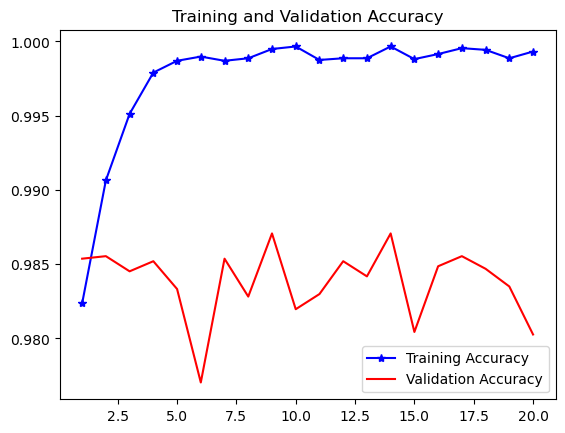

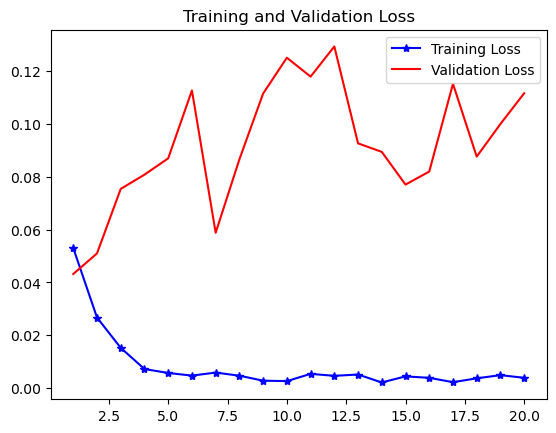

In [22]:
import matplotlib.pyplot as plt
# plot the results

train_acc = history_bert.history['categorical_accuracy']
val_acc = history_bert.history['val_categorical_accuracy']
train_loss = history_bert.history['loss']
val_loss = history_bert.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure() # Creates two independent plots

plt.plot(epochs, train_loss, 'b*-', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [23]:
result_bert = bert_model.predict([test_input_ids,test_attention_masks])

184/184 [==============================] - 76s 395ms/step


In [24]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative Comment', 'Positive Comment']))

	Classification Report for BERT:

                   precision    recall  f1-score   support

Negative Comment       0.54      0.67      0.60       116
Positive Comment       0.99      0.99      0.99      5761

       micro avg       0.98      0.98      0.98      5877
       macro avg       0.77      0.83      0.80      5877
    weighted avg       0.98      0.98      0.98      5877
     samples avg       0.98      0.98      0.98      5877



In [26]:
#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 640x480 with 0 Axes>

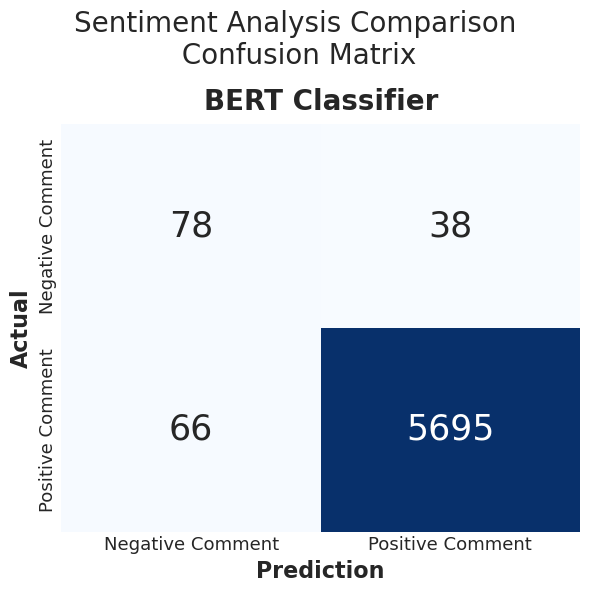

In [27]:
fig, ax = plt.subplots(figsize=(6,6))
labels = ['Negative Comment', 'Positive Comment']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", cbar=False, fmt='g', annot_kws={"size":25})

plt.title('BERT Classifier', fontsize=20)
ax.set_yticklabels(labels, fontsize=13)
ax.set_xticklabels(labels, fontsize=13)
plt.ylabel('Actual', fontsize=16)
plt.xlabel('Prediction', fontsize=16)
plt.show()